In [1]:
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import ticker, cm
from utility import analysis_parameters as ap, util
import numpy as np
import pandas as pd
import dask
from dask.diagnostics import ProgressBar
pbar = ProgressBar()
pbar.register()

colors = ap.COLORS

# Plot accumulated precip 

In [2]:
cumsum=True

In [3]:
models = ["UM", "SAM", "SCREAM", "ARP","GEOS","ICON","SHiELD"]

In [9]:
xr.open_dataset(ap.get_fldmean_file("ARP", "GT", "pr")).pr

<xarray.DataArray 'pr' (time: 2880, lat: 1, lon: 1)>
[2880 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2020-01-30 ... 2020-02-28T23:45:00
  * lon      (lon) float64 0.0
  * lat      (lat) float64 0.0
Attributes:
    standard_name:  precipitation_flux
    param:          8.1.0
    origin:         param8.1.0

0 UM	(2880, 1, 1) 2020-01-30T00:07:30.000000000 2020-01-30T00:22:30.000000000
1 SAM	(2975, 1, 1) 2020-01-30T00:15:00.000000000 2020-01-30T00:30:00.000000000
2 SCREAM	(2976, 1, 1) 2020-01-30 00:00:00 2020-01-30 00:15:00
3 ARP	(2880, 1, 1) 2020-01-30T00:00:00.000000000 2020-01-30T00:15:00.000000000
4 GEOS	(2880, 1, 1) 2020-01-30T00:00:00.000000000 2020-01-30T00:15:00.000000000
5 ICON	(2850, 1, 1) 2020-01-30T00:15:00.000000000 2020-01-30T00:30:00.000000000
6 SHiELD	(2880, 1, 1) 2020-01-30T00:00:00.000000000 2020-01-30T00:15:00.000000000


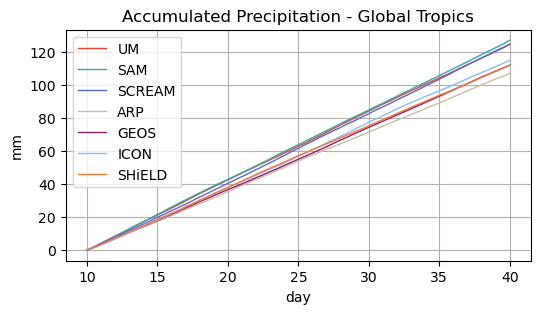

In [13]:
fig, ax = plt.subplots(1,1, figsize=(6,3))

for i, m in enumerate(models):
    print(i, m, end="\t")
    if m=="ICON":
        pr = xr.open_dataset(ap.get_fldmean_file(m, "GT", "pracc")).pracc
    else:
        pr = xr.open_dataset(ap.get_fldmean_file(m, "GT", "pr")).pr
    print(pr.shape, pr.time[0].values, pr.time[1].values)
    pr = pr[:,0,0]
    if m=="ARP":
        pr = pr.cumsum(axis=0)
    elif m=="ICON":
        pr = pr-pr[0]
    elif m!="ICON":
        pr = pr.cumsum(axis=0)*900 # to get in mm (dt = 900s; 1m=1000mm)
    time_array = np.linspace(0,30,len(pr.time))
    if m=="SAM":
        pr = pr/3600
    elif m=="SCREAM":
        pr = pr*1000
    ax.plot(time_array+10, pr[:len(time_array)], color=colors[m], label=m, linewidth=1)
ax.legend()
ax.grid(True)
ax.set_title("Accumulated Precipitation - Global Tropics")
ax.set_ylabel("mm")
ax.set_xlabel("day")
plt.savefig("../plots/GT/pracc_30days.png")
plt.show()

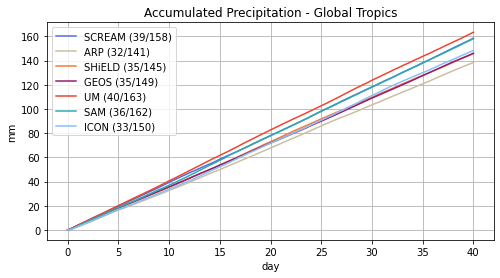

# Land vs ocean precipitation 

GEOS has an ocean/land fraction in the grid file located here: ```/work/ka1081/DYAMOND-WINTER/NASA/GEOS-3km/DW-ATM/atmos/fx/sftlf/r1i1p1f1/ml/gn/sftlf_fx_GEOS-3km_DW-ATM_r1i1p1f1_ml_gn_fx.nc```